# <div align="center">Aim of the code</div>

1) To the XRD data from a .cif file and stores it in a .csv file. This code automate the process for multple cif files
2) To generate the data for neural network, X_train and Y_train. X_train will contain all the intensity values (scaled between 0 and 1) and Y_train will contain the corresponding lattice parameters (a, b,c, alpha, beta, gamma).
3) Train a neural network

## Note:

We will train our model only for P-1 space group

# Libraries

In [4]:
import numpy as np

import os

# import the library for manimulating cif data
import Dans_Diffraction as dif


# Create a function to generate the X_train and Y_train data for machine learning

In [5]:

def generate_data_set(file_paths):
    
    # define relevant parameters
    energy_kev = dif.fc.wave2energy(1.54059)

    count = 0

    # Enter for loop
    for files in file_paths:

        xtl = dif.Crystal(files);         # ; suppresses the output a given line of code
        
        # get the lattice parameters, a,b,c, and alpha, beta, gamma
        lattice_parameters = xtl.Cell.lp();

        # get the 2theta, corresponding intensities, and reflections (h,k, l values (Miler indices)

        xtl.Scatter.setup_scatter(energy_kev=energy_kev, min_twotheta=5, max_twotheta=100, scattering_type='xray', powder_units='tth');
        twotheta, intensity, reflections = xtl.Scatter.powder(units='tth', peak_width=0.01, background=0);

        # since we don't need the reflections and twotheta we can delete it from memory to save RAM
        del(twotheta, reflections)
        
        # scale the intensity between 0 and 1
        intensity /= np.max(intensity);
        
        
        # We don't need all of the points so we will skip some of the 2theta values
        intensity = intensity[0:intensity.size:10]

        if count == 0:
            # Create an empty numpy array to store X_train
            X_train = np.empty((len(file_paths), intensity.size));

            # Create an empty numpy array to store Y_train
            Y_train = np.empty((len(file_paths), len(lattice_parameters)));


        # create X_train containing intensity values for all two theta along a row.
        X_train[count] = intensity;
        Y_train[count] = np.array(lattice_parameters);


        count += 1        # this simply means count = count + 1
    
    del(intensity)        # delete the intensity matrix at the end to clear up RAM
    
    return X_train, Y_train


# Create the X and Y training data

In [6]:
X_train = np.genfromtxt('./training_data/cleaned_training_data/X_train.csv', delimiter=',')

Y_train = np.genfromtxt('./training_data/cleaned_training_data/Y_train.csv', delimiter=',')


In [7]:
print(X_train.shape, Y_train.shape)

(792, 1179) (792, 6)


# Scale Y_train from 0 to 1, X_train is already scaled

In [8]:
a_max = np.max(Y_train[:,0])         # maximum of a
b_max = np.max(Y_train[:,1])         # maximum of b
c_max = np.max(Y_train[:,2])         # maximum of c

alpha_max = np.max(Y_train[:,3])     # maximum of alpha
beta_max  = np.max(Y_train[:,4])     # maximum of beta
gamma_max = np.max(Y_train[:,5])     # maximum of gamma


Y_train[:,0] *= 1/a_max;             # this means mutiplication of 0th column with 1/a_max

Y_train[:,1] *= 1/b_max;

Y_train[:,2] *= 1/c_max;

Y_train[:,3] *= 1/alpha_max;
Y_train[:,4] *= 1/beta_max;
Y_train[:,5] *= 1/gamma_max;


# Take last 5 rows out of the training data for testing the model

In [9]:
X_test = X_train[X_train[:,0].size - 5: X_train[:,0].size, :]
Y_test = Y_train[Y_train[:,0].size - 5: Y_train[:,0].size, :]

print(X_test.shape, Y_test.shape)

(5, 1179) (5, 6)


# Delete last 5 rows from the X_train and Y_train

In [10]:
X_train = np.delete(X_train, np.arange(X_train[:,0].size-5,X_train[:,0].size, 1), axis=0);
Y_train = np.delete(Y_train, np.arange(Y_train[:,0].size-5,Y_train[:,0].size, 1), axis=0);

print(X_train.shape, Y_train.shape)

(787, 1179) (787, 6)


# Check if data is correctly generated

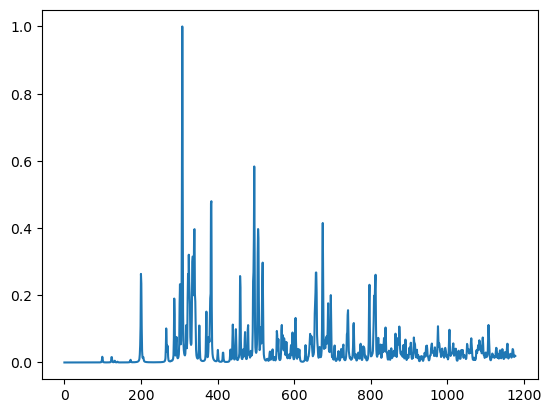

In [11]:
import matplotlib.pyplot as plt

plt.plot(X_train[16])

# Create your multiple output MLP model

In [12]:
# Libraries
from keras.models import Sequential
from keras.layers import Dense

# get the model
def get_model(n_inputs, n_outputs):
    
    # Define your Keras model here
    model = Sequential()

    # The Input Layer :
    model.add(Dense(1024, kernel_initializer='normal', bias_initializer='normal', input_dim = n_inputs, activation='relu'))

    # The Hidden Layers :
    model.add(Dense(1024, kernel_initializer='normal',bias_initializer='normal', activation='relu'))
    model.add(Dense(512, kernel_initializer='normal',bias_initializer='normal', activation='relu'))
    model.add(Dense(512, kernel_initializer='normal',bias_initializer='normal', activation='relu'))

    # The Output Layer :
    model.add(Dense(n_outputs, kernel_initializer='normal',bias_initializer='normal', activation='sigmoid'))
  

    # Compile the network :
#    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

#    model.compile(loss='mae', optimizer='adam')
    return model

# Train the model

In [13]:
n_inputs, n_outputs = X_train[0].size, Y_train[0].size

# get model
model = get_model(n_inputs, n_outputs)

# fit the model on all data
model.fit(X_train, Y_train, epochs=200,verbose = 1)


Epoch 1/200
25/25 [==============================] - 2s 32ms/step - loss: 0.0857 - accuracy: 0.3215
Epoch 2/200
25/25 [==============================] - 1s 30ms/step - loss: 0.0472 - accuracy: 0.5464
Epoch 3/200
25/25 [==============================] - 1s 30ms/step - loss: 0.0385 - accuracy: 0.5642
Epoch 4/200
25/25 [==============================] - 1s 30ms/step - loss: 0.0312 - accuracy: 0.5756
Epoch 5/200
25/25 [==============================] - 1s 32ms/step - loss: 0.0279 - accuracy: 0.6290
Epoch 6/200
25/25 [==============================] - 1s 32ms/step - loss: 0.0249 - accuracy: 0.6620
Epoch 7/200
25/25 [==============================] - 1s 33ms/step - loss: 0.0237 - accuracy: 0.7865
Epoch 8/200
25/25 [==============================] - 1s 32ms/step - loss: 0.0198 - accuracy: 0.7776
Epoch 9/200
25/25 [==============================] - 1s 38ms/step - loss: 0.0193 - accuracy: 0.7776
Epoch 10/200
25/25 [==============================] - 1s 33ms/step - loss: 0.0171 - accuracy: 0.8602

25/25 [==============================] - 1s 32ms/step - loss: 0.0051 - accuracy: 0.9860
Epoch 83/200
25/25 [==============================] - 1s 32ms/step - loss: 0.0051 - accuracy: 0.9809
Epoch 84/200
25/25 [==============================] - 1s 32ms/step - loss: 0.0058 - accuracy: 0.9848
Epoch 85/200
25/25 [==============================] - 1s 31ms/step - loss: 0.0054 - accuracy: 0.9835
Epoch 86/200
25/25 [==============================] - 1s 32ms/step - loss: 0.0052 - accuracy: 0.9759
Epoch 87/200
25/25 [==============================] - 1s 31ms/step - loss: 0.0052 - accuracy: 0.9911
Epoch 88/200
25/25 [==============================] - 1s 32ms/step - loss: 0.0046 - accuracy: 0.9873
Epoch 89/200
25/25 [==============================] - 1s 31ms/step - loss: 0.0049 - accuracy: 0.9835
Epoch 90/200
25/25 [==============================] - 1s 32ms/step - loss: 0.0047 - accuracy: 0.9822
Epoch 91/200
25/25 [==============================] - 1s 32ms/step - loss: 0.0050 - accuracy: 0.9822
Epo

25/25 [==============================] - 1s 36ms/step - loss: 0.0039 - accuracy: 0.9936
Epoch 163/200
25/25 [==============================] - 1s 43ms/step - loss: 0.0038 - accuracy: 0.9962
Epoch 164/200
25/25 [==============================] - 1s 32ms/step - loss: 0.0039 - accuracy: 0.9860
Epoch 165/200
25/25 [==============================] - 1s 32ms/step - loss: 0.0036 - accuracy: 0.9873
Epoch 166/200
25/25 [==============================] - 1s 32ms/step - loss: 0.0037 - accuracy: 0.9936
Epoch 167/200
25/25 [==============================] - 1s 32ms/step - loss: 0.0036 - accuracy: 0.9886
Epoch 168/200
25/25 [==============================] - 1s 32ms/step - loss: 0.0038 - accuracy: 0.9911
Epoch 169/200
25/25 [==============================] - 1s 32ms/step - loss: 0.0038 - accuracy: 0.9949
Epoch 170/200
25/25 [==============================] - 1s 32ms/step - loss: 0.0039 - accuracy: 0.9949
Epoch 171/200
25/25 [==============================] - 1s 32ms/step - loss: 0.0038 - accuracy: 0

# Make prediction

In [14]:
# Create an empty list to store the paths of all .cif files
file_paths = []

training_data_directory = './training_data/cif_files/P6_slash_mmm/'             # ./ means current directory

for file in os.listdir(training_data_directory):
    if ".cif" in file:
        file_paths.append('./training_data/cif_files/P6_slash_mmm/' + file)

In [28]:
%%capture

# The above line of code supresses the output of this entire cell
X_test, Y_test = generate_data_set(file_paths[500:600]);    

In [16]:
X_test

array([[5.64023805e-06, 5.66636993e-06, 5.69269493e-06, ...,
        6.65966215e-05, 6.40359710e-05, 6.15009599e-05],
       [2.84571031e-06, 2.85824178e-06, 2.87085950e-06, ...,
        1.48534102e-03, 8.27928304e-04, 5.37969251e-04],
       [3.71947210e-05, 3.76433187e-05, 3.81012974e-05, ...,
        1.08607776e-03, 9.12174382e-04, 7.81732281e-04],
       ...,
       [6.65364789e-06, 6.68790029e-06, 6.72243789e-06, ...,
        2.44682236e-04, 2.17715108e-04, 1.95606192e-04],
       [1.49428422e-05, 1.51333889e-05, 1.53297330e-05, ...,
        1.58486801e-01, 1.18073481e-01, 3.35719279e-02],
       [1.43660778e-05, 1.45455504e-05, 1.47304312e-05, ...,
        1.62587508e-01, 9.21169868e-02, 2.46362460e-02]])

In [49]:
Y_test

array([[  4.23   ,   4.23   ,   4.     ,  90.     ,  90.     , 120.     ],
       [  3.989  ,   3.989  ,   4.086  ,  90.     ,  90.     , 120.     ],
       [  4.075  ,   4.075  ,   4.386  ,  90.     ,  90.     , 120.     ],
       [  4.046  ,   4.046  ,   4.5    ,  90.     ,  90.     , 120.     ],
       [  5.035  ,   5.035  ,   4.07   ,  90.     ,  90.     , 120.     ],
       [  3.973  ,   3.973  ,   4.179  ,  90.     ,  90.     , 120.     ],
       [  4.37   ,   4.37   ,   3.45   ,  90.     ,  90.     , 120.     ],
       [  4.994  ,   4.994  ,   3.985  ,  90.     ,  90.     , 120.     ],
       [  4.973  ,   4.973  ,   3.983  ,  90.     ,  90.     , 120.     ],
       [  4.9    ,   4.9    ,   4.1    ,  90.     ,  90.     , 120.     ],
       [  4.86   ,   4.86   ,   4.1    ,  90.     ,  90.     , 120.     ],
       [  4.86   ,   4.86   ,   4.     ,  90.     ,  90.     , 120.     ],
       [  4.052  ,   4.052  ,   4.482  ,  90.     ,  90.     , 120.     ],
       [  5.026  ,   5.02

In [64]:
from numpy import asarray

# for i in range(Y_test[:,0].size):
#     X    = asarray([X_test[i]])
#     yhat = model.predict(X)
#     y    = asarray([Y_test[i]])


predicted = np.empty([100, 6])
j=0
for x, y in zip(X_test, Y_test):
    X    = asarray([x])
    Yhat = model.predict(X)
    Y    = asarray([y])
        

    Yhat[0,0] *=a_max;
    Yhat[0,1] *=b_max;
    Yhat[0,2] *=c_max;
    Yhat[0,3] *=alpha_max;
    Yhat[0,4] *=beta_max;
    Yhat[0,5] *=gamma_max;
    
#     Y[0,0] *=a_max;
#     Y[0,1] *=b_max;
#     Y[0,2] *=c_max;
#     Y[0,3] *=alpha_max;
#     Y[0,4] *=beta_max;
#     Y[0,5] *=gamma_max;
    

    print(' Predicted         : %s' % Yhat[0][0:6])
    print(' Actual            : %s' % Y[0][0:6])
    print(' percentage errors : %s' % np.abs(np.divide((Y[0][0:6] - Yhat[0][0:6])*100,Y[0][0:6])))
    print(" ")
    predicted[j] = Yhat
    j+=1


1/1 [==============================] - 0s 30ms/step
 Predicted         : [  3.765492    3.7872357   3.932605   89.72992    89.51925   114.24908  ]
 Actual            : [  4.23   4.23   4.    90.    90.   120.  ]
 percentage errors : [10.98127748 10.46724026  1.6848743   0.30008952  0.53416782  4.79243596]
 
1/1 [==============================] - 0s 28ms/step
 Predicted         : [  3.619925    3.6178322   3.976052   89.53221    89.358055  118.07711  ]
 Actual            : [  3.989   3.989   4.086  90.     90.    120.   ]
 percentage errors : [9.25231832 9.30478356 2.69084567 0.51976522 0.71327209 1.60240809]
 
1/1 [==============================] - 0s 28ms/step
 Predicted         : [  4.82932    4.717386   5.532263  89.832146  89.182495 118.82952 ]
 Actual            : [  4.075   4.075   4.386  90.     90.    120.   ]
 percentage errors : [18.51091911 15.76406795 26.13458281  0.18650479  0.90833876  0.97539902]
 
1/1 [==============================] - 0s 29ms/step
 Predicted         : 

 Predicted         : [  4.7573147   4.823784    4.1132503  89.89304    89.90181   119.90516  ]
 Actual            : [  5.024   5.024   4.034  90.     90.    120.   ]
 percentage errors : [5.30822687 3.98519358 1.96455765 0.11884054 0.10910034 0.07903417]
 
1/1 [==============================] - 0s 28ms/step
 Predicted         : [  3.97545    4.025969   4.402504  89.674934  89.645195 119.83117 ]
 Actual            : [  5.12   5.12   3.99  90.    90.   120.  ]
 percentage errors : [22.35449143 21.36779241 10.3384453   0.36118401  0.39422777  0.14069239]
 
1/1 [==============================] - 0s 28ms/step
 Predicted         : [ 3.8938215  3.95006    5.061962  89.82737   89.92448   90.29658  ]
 Actual            : [  4.942   4.942   3.54   90.     90.    120.   ]
 percentage errors : [21.20960182 20.07163313 42.99328044  0.19181146  0.08391486 24.75285212]
 
1/1 [==============================] - 0s 29ms/step
 Predicted         : [  3.600421    3.6055818   3.7185538  89.57875    89.64475

1/1 [==============================] - 0s 27ms/step
 Predicted         : [  4.3989697   4.445338    3.9514327  89.62585    89.806435  119.90979  ]
 Actual            : [  5.      5.      4.002  90.     90.    120.   ]
 percentage errors : [12.02060699 11.09324455  1.2635506   0.41572571  0.21507263  0.07517497]
 
1/1 [==============================] - 0s 29ms/step
 Predicted         : [  4.780907    4.799663    4.4423313  89.67534    89.68506   119.92084  ]
 Actual            : [  5.013   5.013   4.025  90.     90.    120.   ]
 percentage errors : [ 4.62981939  4.25567391 10.36847985  0.36073473  0.3499349   0.06596883]
 
1/1 [==============================] - 0s 29ms/step
 Predicted         : [  3.679791    3.6932154   3.4457335  89.69625    89.73128   119.52147  ]
 Actual            : [  4.953   4.953   4.027  90.     90.    120.   ]
 percentage errors : [25.70581519 25.43477952 14.43423027  0.33749898  0.29858059  0.39877574]
 
1/1 [==============================] - 0s 29ms/step
 Pr

1/1 [==============================] - 0s 28ms/step
 Predicted         : [  5.226866    5.2270455   8.13396    89.55948    89.915955  119.98098  ]
 Actual            : [  5.2027   5.2027   8.1744  90.      90.     120.    ]
 percentage errors : [0.46448514 0.46794042 0.49471802 0.48946804 0.09338379 0.01585007]
 
1/1 [==============================] - 0s 29ms/step
 Predicted         : [  5.162966    5.2138      7.8699603  89.68493    89.95922   119.969536 ]
 Actual            : [  5.1836   5.1836   8.1567  90.      90.     120.    ]
 percentage errors : [0.39806747 0.58260578 3.51538848 0.35007901 0.04531013 0.02538681]
 
1/1 [==============================] - 0s 29ms/step
 Predicted         : [  5.2087536   5.2066383   8.081651   89.52825    89.96252   119.98999  ]
 Actual            : [  5.2077   5.2077   8.1423  90.      90.     120.    ]
 percentage errors : [0.02023131 0.02038642 0.74486651 0.52416484 0.04164802 0.00834147]
 
1/1 [==============================] - 0s 29ms/step
 Pr

In [51]:
predicted

array([[  3.76549196,   3.78723574,   3.93260503,  89.72991943,
         89.51924896, 114.24907684],
       [  3.61992502,   3.61783218,   3.97605205,  89.5322113 ,
         89.35805511, 118.07711029],
       [  4.82931995,   4.71738577,   5.5322628 ,  89.83214569,
         89.18249512, 118.82952118],
       [  4.2016468 ,   4.38207769,   5.82505274,  89.79407501,
         89.56787872, 109.85658264],
       [  5.031003  ,   5.21199751,   3.81663513,  90.53032684,
         90.67761993, 119.70786285],
       [  3.60819101,   3.63919258,   3.80087614,  89.81558228,
         89.7012558 , 118.06745148],
       [  3.50737906,   3.52004123,   3.64149904,  89.91879272,
         89.80471802,  91.26898956],
       [  3.96956778,   3.9844265 ,   3.72498107,  89.6645813 ,
         89.70440674, 119.54106903],
       [  3.82702827,   3.86141849,   3.42901039,  89.6934967 ,
         89.74517059, 119.75202942],
       [  3.51345062,   3.51755977,   3.77914834,  89.64588165,
         89.78610229, 119.9

# Note:
Python is case sensitive i.e., two variables named "a" and "A" are considered different variables

# Plot the confusion matrix

1
2
3


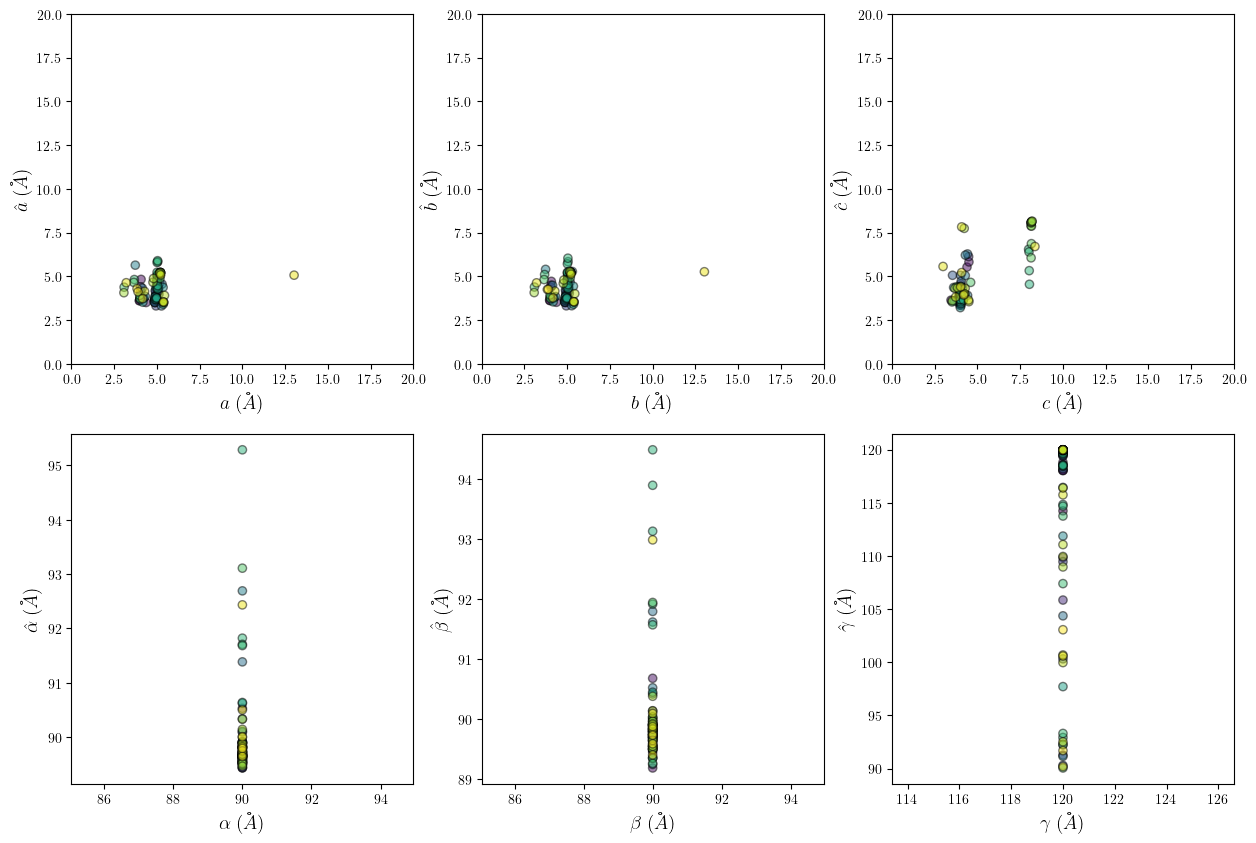

In [63]:
def plot_confusion_matrix(y, yhat):
    
    import matplotlib.pyplot as plt
    plt.rcParams['text.usetex'] = True
    
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize = (15,10))

    plt.setp(axs[0], xlim=(0, 20), ylim=(0, 20))         # set a common xlimit and ylimit for all subplots

    colors = np.arange(y[:,0].size)                  # colors are set such a way that the first point plotted will be the darkest and last point plotted will be lightest

    angles = ['alpha', 'beta', 'gamma']

    j = 0
    k = [3,4,5]
    for i in range(97, 97+3):
        # 1st row
        axs[0,j].set_xlabel(r'$%s\; (\r{A})$' % chr(i), fontsize = 14)
        axs[0,j].set_ylabel(r'$\hat{%s}\; (\r{A})$' % chr(i), fontsize = 14)
        axs[0,j].scatter(Y_test[:, j], yhat[:, j], c=colors, cmap = 'viridis', edgecolor = 'black', alpha = 0.5)
        
        # 2nd row
        axs[1,j].set_xlabel(r'$\%s\; (\r{A})$' % angles[j], fontsize = 14)
        axs[1,j].set_ylabel(r'$\hat{\%s}\; (\r{A})$' % angles[j], fontsize = 14)
        axs[1,j].scatter(Y_test[:, k[j]], yhat[:, k[j]], c=colors, cmap = 'viridis', edgecolor = 'black', alpha = 0.5)
        
        
        j += 1
        
        print(j)
        
    
#     axs[1,0].scatter(Y_test[:, 3], yhat[:, 3], c=colors, cmap = 'viridis', edgecolor = 'black', alpha = 0.5)
#     axs[1,1].scatter(Y_test[:, 4], yhat[:, 4], c=colors, cmap = 'viridis', edgecolor = 'black', alpha = 0.5)
#     axs[1,2].scatter(Y_test[:, 5], yhat[:, 5], c=colors, cmap = 'viridis', edgecolor = 'black', alpha = 0.5)
     
        
        

    plt.show()

plot_confusion_matrix(Y_test, predicted)    

# Note:

%d means integer<br>
%s means strings